<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune the Vision Transformer on CIFAR-10

In this notebook, we are going to fine-tune a pre-trained Vision Transformer. This dataset is a collection of 60,000 32x32 colour images in 10 classes, with 6000 images per class.


### Vision Transformer (ViT)

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

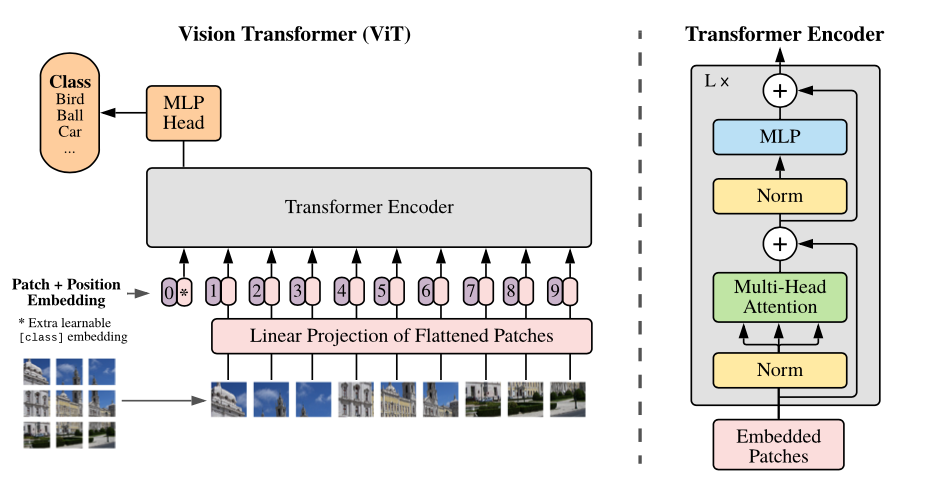

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


Let's start by installing the relevant libraries.

In [ ]:
!pip install -q transformers datasets pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 28.6 MB/s eta 0:00:00


### Mount data in google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root_path = '/content/drive/MyDrive/vit_cifar10'

### Check GPU devices


In [ ]:
import torch

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())
print("cuda version: ", torch.version.cuda if torch.cuda.is_available() else "none")

pytorch version:  2.0.1+cu118
cuda available:  True
cuda version:  11.8


In [ ]:
# check if GPU is available in computer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# count the number of gpus
num_gpus = torch.cuda.device_count()

if num_gpus:
    print("num gpus: ", num_gpus)

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("no GPUs are founded")

num gpus:  1
GPU 0: Tesla T4


## Load the data

Here we import a small portion of CIFAR-10, for demonstration purposes. This dataset can be found on the [hub](https://huggingface.co/datasets/cifar10) (you can view images directly in your browser!).

In [ ]:
import numpy as np
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
dataset = load_dataset('cifar10')
print(len(dataset['train']))
print(len(dataset['test']))

In [ ]:
import numpy as np
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
dataset = load_dataset('cifar10')

# define train and test sets
train_set = dataset['train']
test_ds = dataset['test']

# split data: 90% for train and 10% for validation
train_length = len(train_set)
split_point = int(train_length * 0.9)

# shuffle indexes in random distribution
indexes = np.random.permutation(train_length)
train_idx = indexes[:split_point]
val_idx = indexes[split_point:]

# split up train set and validation set
train_ds = train_set.select(train_idx)
val_ds = train_set.select(val_idx)

print("#train samples = ", len(train_ds))
print("#val samples = ", len(val_ds))
print("#test samples = ", len(test_ds))

#train samples =  45000
#val samples =  5000
#test samples =  10000


In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

We can also check out the features of the dataset in more detail:

In [ ]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

As we can see, each example has 2 features: 'img' (of type `Image`) and 'label' (of type `ClassLabel`). Let's check an example of the training dataset:

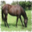

In [ ]:
train_ds[0]['img']

In [ ]:
train_ds[0]['label']

7

Of course, we would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
id2label[train_ds[0]['label']]

'horse'

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`.

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

We first load the image processor, which is a minimal object that can be used to prepare images for inference. We use some of its properties which are relevant for preparing images for the model.

In [ ]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [ ]:
print(size)

224


For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [ ]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [7, 8],
 'pixel_values': [tensor([[[-0.6314, -0.6314, -0.6314,  ...,  0.3725,  0.3725,  0.3725],
           [-0.6314, -0.6314, -0.6314,  ...,  0.3725,  0.3725,  0.3725],
           [-0.6314, -0.6314, -0.6314,  ...,  0.3725,  0.3725,  0.3725],
           ...,
           [-0.0510, -0.0510, -0.0510,  ..., -0.1608, -0.1608, -0.1608],
           [-0.0510, -0.0510, -0.0510,  ..., -0.1608, -0.1608, -0.1608],
           [-0.0510, -0.0510, -0.0510,  ..., -0.1608, -0.1608, -0.1608]],
  
          [[-0.5294, -0.5294, -0.5294,  ...,  0.3804,  0.3804,  0.3804],
           [-0.5294, -0.5294, -0.5294,  ...,  0.3804,  0.3804,  0.3804],
           [-0.5294, -0.5294, -0.5294,  ...,  0.3804,  0.3804,  0.3804],
           ...,
           [ 0.1216,  0.1216,  0.1216,  ...,  0.0902,  0.0902,  0.0902],
           [ 0.1216,  0.1216,  0.1216,  ...,  0.0902,  0.0902,  0.

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 64
eval_batch_size = 64

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64])


In [ ]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [ ]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([64, 3, 224, 224])

## Define the model

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.


### Training process Using normal pytorch

In [ ]:
# import packages
import torch
from torch.optim import AdamW
from transformers import ViTForImageClassification
import torch.nn as nn

In [ ]:
# class of ViT model with transfer learning

class ViTModel(torch.nn.Module):
    def __init__(self, num_labels=10):
        super(ViTModel, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def total_parameters(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
# process of training model
def train(model, train_loader, device, optimizer):
    model.train()
    train_loss = 0
    num_correct = 0
    criterion = nn.CrossEntropyLoss()

    for batch in train_loader:
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predictions = logits.argmax(-1)
        num_correct += (predictions == labels).sum().item()

    accuracy = num_correct / len(train_loader.dataset)

    return train_loss / len(train_loader), accuracy

# process to validate model
def validate(model, val_loader, device):
    model.eval()
    val_loss = 0
    num_correct = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values']
            labels = batch['labels']
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            logits = model(pixel_values)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            predictions = logits.argmax(-1)
            num_correct += (predictions == labels).sum().item()

    accuracy = num_correct / len(val_loader.dataset)

    return val_loss / len(val_loader), accuracy

# process to test model
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values']
            labels = batch['labels']
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            logits = model(pixel_values)
            loss = criterion(logits, labels)

            test_loss += loss.item()
            predictions = logits.argmax(-1)
            num_correct += (predictions == labels).sum().item()

    accuracy = num_correct / len(test_loader.dataset)

    return test_loss / len(test_loader), accuracy

In [ ]:
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# send model to gpu memory
model = ViTModel()
model = model.to(device)

# define optimized method
optimizer = AdamW(model.parameters(), lr=5e-5)

cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# architecture of the model
model

ViTModel(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermed

In [ ]:
print(root_path)

/content/drive/MyDrive/vit_cifar10


In [ ]:
!ls /content/drive/MyDrive/vit_cifar10

models	vit_on_cifar10_v5.ipynb


In [ ]:
# num_epochs: the number of epochs you want to train for
num_epochs = 10

# initialize the best validation accuracy
best_val_accuracy = 0.0

# set the saved model
model_save_path = "/models/cifar10_vit_model"

# process of training
for epoch in range(num_epochs):
    print("Training process...")
    train_loss, train_accuracy = train(model, train_dataloader, device, optimizer)
    val_loss, val_accuracy = validate(model, val_dataloader, device)
    print(f"Epoch {epoch}/{num_epochs} =====> Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_filename = root_path + model_save_path + str(epoch) + ".pt"
        torch.save(model.state_dict(), model_filename)
        print(f"*** Model saved at epoch {epoch}/{num_epochs} with validation accuracy = {best_val_accuracy:.4f} ***")
print("Training finished!")

Training process...
Epoch 0/10 =====> Train Loss: 0.5515, Train Accuracy: 0.8763, Validation Loss: 0.1066, Validation Accuracy: 0.9810
*** Model saved at epoch 0/10 with validation accuracy = 0.9810 ***
Training process...
Epoch 1/10 =====> Train Loss: 0.2705, Train Accuracy: 0.9178, Validation Loss: 0.0547, Validation Accuracy: 0.9870
*** Model saved at epoch 1/10 with validation accuracy = 0.9870 ***
Training process...
Epoch 2/10 =====> Train Loss: 0.2325, Train Accuracy: 0.9261, Validation Loss: 0.0464, Validation Accuracy: 0.9880
*** Model saved at epoch 2/10 with validation accuracy = 0.9880 ***
Training process...
Epoch 3/10 =====> Train Loss: 0.2143, Train Accuracy: 0.9299, Validation Loss: 0.0501, Validation Accuracy: 0.9864
Training process...
Epoch 4/10 =====> Train Loss: 0.2016, Train Accuracy: 0.9335, Validation Loss: 0.0433, Validation Accuracy: 0.9870
Training process...
Epoch 5/10 =====> Train Loss: 0.1921, Train Accuracy: 0.9367, Validation Loss: 0.0390, Validation Acc

Monitor the performance result of best model

In [ ]:
# path of the best model
model_best_path = "/models/cifar10_vit_model5.pt"

In [ ]:
# create new instance of model
best_model = ViTModel()

# load the saved state_dict into the instance
best_model.load_state_dict(torch.load(root_path + model_best_path))

# move the model to device
best_model = best_model.to(device)

test_loss, test_accuracy = test(best_model, test_dataloader, device)
print(f"Testing process... =====> Test-loss: {test_loss:.4f} , Test-accuracy: {test_accuracy:.4f}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing process... =====> Test-loss: 0.0516 , Test-accuracy: 0.9854


Results

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

def plot_results(vec1, vec2, y_title):
    plt.figure(figsize=(8, 6))
    plt.plot(vec1, vec2, 'b-o')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title('Epochs vs ' + y_title)
    plt.grid(True)
    plt.show()

In [2]:
train_res = {
    "loss": [0.5515, 0.2705, 0.2325, 0.2143, 0.2016, 0.1921, 0.1817, 0.1798, 0.1728],
    "accuracy": [0.8763, 0.9178, 0.9261, 0.9299, 0.9335, 0.9367, 0.9389, 0.9400, 0.9418]
}

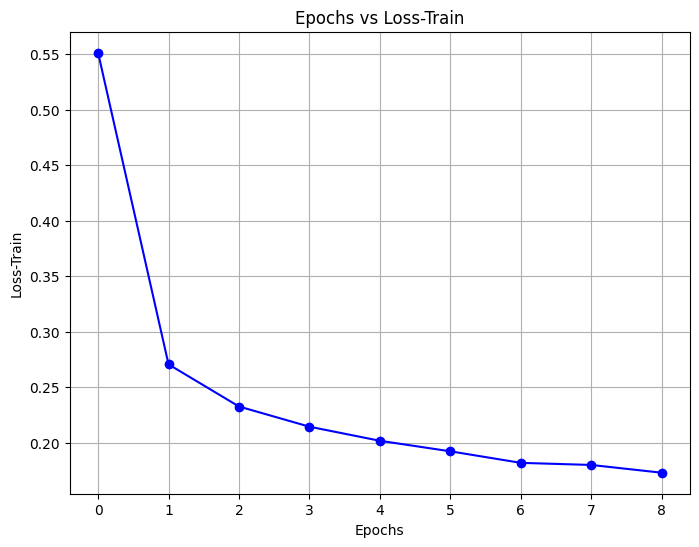

In [3]:
plot_results(np.arange(9), train_res["loss"], "Loss-Train")

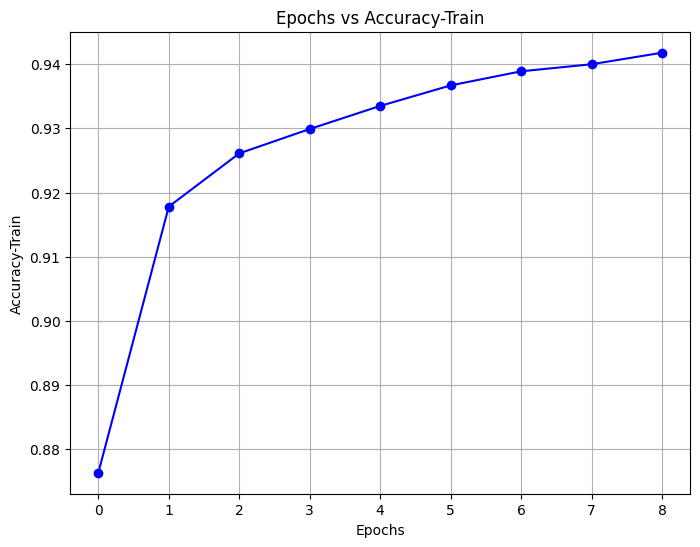

In [4]:
plot_results(np.arange(9), train_res["accuracy"], "Accuracy-Train")

In [5]:
val_res = {
    "loss": [0.1066, 0.0547, 0.0464, 0.0501, 0.0433, 0.0390, 0.0408, 0.0422, 0.0441],
    "accuracy": [0.9810, 0.9870, 0.9880, 0.9864, 0.9870, 0.9884, 0.9882, 0.9862, 0.9858]
}

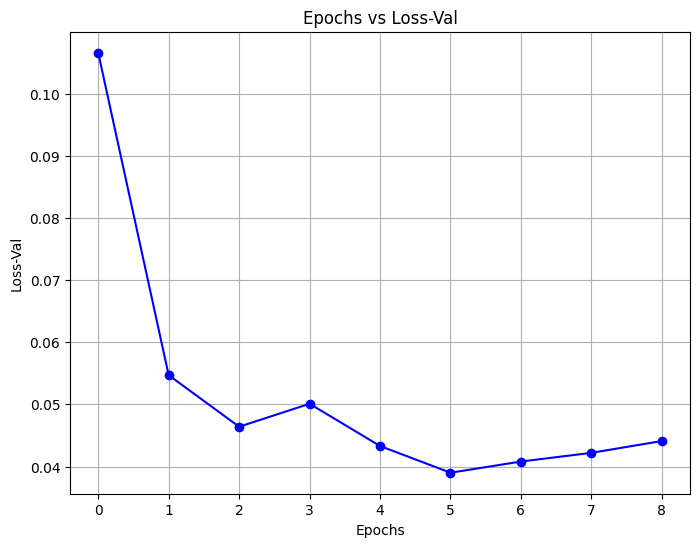

In [6]:
plot_results(np.arange(9), val_res["loss"], "Loss-Val")

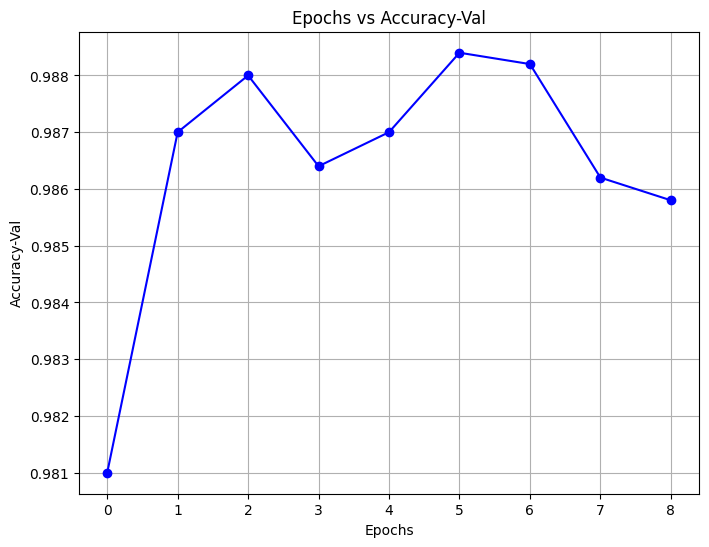

In [7]:
plot_results(np.arange(9), val_res["accuracy"], "Accuracy-Val")

End of train/validation process!